In [39]:
# notebook to recreate Mingkang's simulation of qubit-SNAIL coupling gates
# using my refactored version of his code

In [40]:
import numpy as np
from qutip import Options
import qutip as qt
from pathlib import Path
import matplotlib.pyplot as plt
from quantum_logical.pulsesim import QuantumSystem, Pulse
from quantum_logical.pulsesim.hamiltonian import QubitQubitSNAIL

opts = Options(nsteps=1e6, atol=1e-8, rtol=1e-6)
p_bar = qt.ui.TextProgressBar()  # None

In [42]:
# Better, load from YAML file
# Ensure the correct path relative to the project root
project_root = Path("/home/evm9/quantum_logical")  # Adjust as necessary
yaml_file = (
    project_root / "src/quantum_logical/pulsesim/system_params/system_params.yaml"
)
quantum_system = QuantumSystem.from_yaml(yaml_file)

In [43]:
system_hamiltonian = QubitQubitSNAIL(quantum_system, use_TLS=True, use_RWA=False)
q1_mode = system_hamiltonian.q1_mode
q2_mode = system_hamiltonian.q2_mode

# prepare an initial state
psi0 = quantum_system.prepare_tensor_fock_state([(q2_mode, 1)])

In [44]:
system_hamiltonian.H

Quantum object: dims = [[2, 2, 10], [2, 2, 10]], shape = (40, 40), type = oper, isherm = True
Qobj data =
[[-30.19419257   0.9424778    0.         ...   0.           0.
    0.        ]
 [  0.9424778   -3.3326329    2.66572976 ...   0.           0.
    0.        ]
 [  0.           2.66572976  23.52892676 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ... 218.22511023  21.3258381
    0.        ]
 [  0.           0.           0.         ...  21.3258381  245.0866699
   16.02212253]
 [  0.           0.           0.         ...   0.          16.02212253
  271.94822956]]

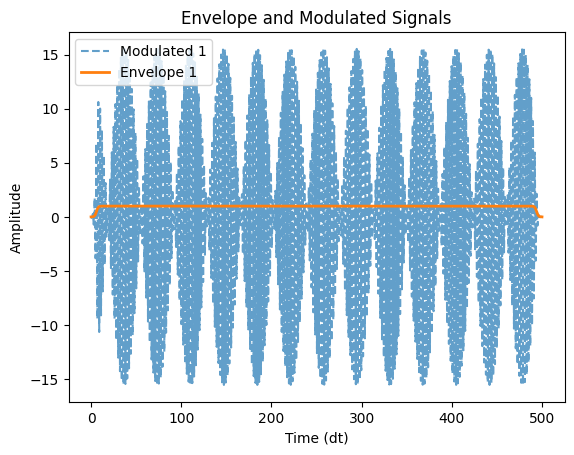

In [45]:
# Define experiment constants
# define frequency and amplitude ranges
# drive at qubit-qubit conversion with some detuning
width_d = 500
N = 30

detuning_flist = 1000 * np.linspace(-0.01, 0.01, N)  # MHz
flist = 2 * np.pi / 1000 * (detuning_flist) + abs(q1_mode.freq - q2_mode.freq)
alist = np.linspace(0, 30, N)
args = {"shape": Pulse.smoothbox, "shape_params": {"t0": 0, "width": width_d}}
t_list = np.linspace(0, width_d, 500)

# plot an example pulse from the experiment to verify its shape
omega_p = flist[int(N / 2)]
amp_p = alist[int(N / 2)]
pulse = Pulse(omega=omega_p, amp=amp_p)

# Plot the Gaussian pulse shape
Pulse.plot_pulse([(pulse, args)], t_list)

In [8]:
def simulation_task(freq_amp_tuple):
    freq, amp = freq_amp_tuple
    pulse = Pulse(omega=freq, amp=amp)
    H = system_hamiltonian.driven(pulse)
    solve_result = qt.mesolve(H, psi0, t_list, args=args, options=opts)
    final_state = solve_result.states[-1]
    ground_state_populations = [
        quantum_system.mode_population_expectation(final_state, mode, 0)
        for mode in quantum_system.modes
    ]
    return ground_state_populations


# Prepare the parameters for parallel execution
freq_amp_pairs = [(f, a) for f in flist for a in alist]

# Run the simulations in parallel
results = qt.parallel.parallel_map(simulation_task, freq_amp_pairs, progress_bar=True)

# Process results
ground_state_populations = np.zeros((len(quantum_system.modes), len(alist), len(flist)))
for idx, (freq, amp) in enumerate(freq_amp_pairs):
    freq_idx = np.where(flist == freq)[0][0]
    amp_idx = np.where(alist == amp)[0][0]

    populations = results[idx]
    for k, pop in enumerate(populations):
        ground_state_populations[k, amp_idx, freq_idx] = pop

10.0%. Run time:  91.49s. Est. time left: 00:00:13:43
20.0%. Run time: 172.08s. Est. time left: 00:00:11:28
30.0%. Run time: 245.37s. Est. time left: 00:00:09:32
40.0%. Run time: 321.67s. Est. time left: 00:00:08:02
50.0%. Run time: 399.46s. Est. time left: 00:00:06:39
60.0%. Run time: 474.34s. Est. time left: 00:00:05:16
70.0%. Run time: 552.97s. Est. time left: 00:00:03:56
80.0%. Run time: 631.39s. Est. time left: 00:00:02:37
90.0%. Run time: 710.22s. Est. time left: 00:00:01:18
100.0%. Run time: 786.71s. Est. time left: 00:00:00:00
Total run time: 786.72s


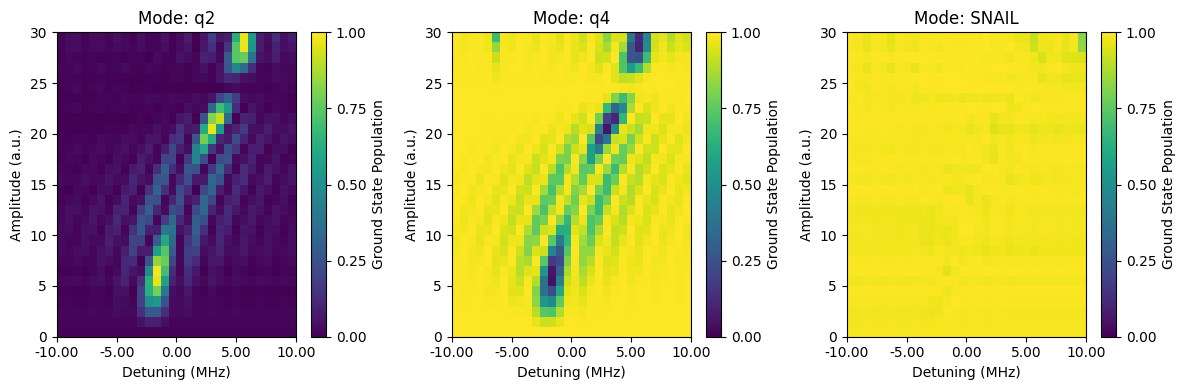

In [9]:
# Prepare the plot
fig, axes = plt.subplots(
    1, len(quantum_system.modes), figsize=(len(quantum_system.modes) * 4, 4)
)

# Conversion factor from radian frequency to GHz
rad_to_GHz = 1 / (2 * np.pi)

# Define the number of ticks for the detuning x-axis
n_xticks = 5  # Adjust the number of ticks as needed

# Plot data for each mode
for k, mode in enumerate(quantum_system.modes):
    im = axes[k].imshow(
        ground_state_populations[k],
        # extent=[flist[0] * rad_to_GHz, flist[-1] * rad_to_GHz, alist[0], alist[-1]],
        extent=[detuning_flist[0], detuning_flist[-1], alist[0], alist[-1]],
        aspect="auto",
        origin="lower",
        vmin=0.0,
        vmax=1.0,  # Set color bar scale from 0.0 to 1.0
    )
    axes[k].set_title(f"Mode: {mode.name}")
    # axes[k].set_xlabel("Frequency (GHz)")
    axes[k].set_xlabel("Detuning (MHz)")
    axes[k].set_ylabel("Amplitude (a.u.)")

    # Customize x-axis ticks
    # xticks = np.linspace(flist[0] * rad_to_GHz, flist[-1] * rad_to_GHz, n_xticks)
    xticks = np.linspace(detuning_flist[0], detuning_flist[-1], n_xticks)
    axes[k].set_xticks(xticks)
    axes[k].set_xticklabels([f"{x:.2f}" for x in xticks])  # Format the tick labels

    # Add color bar
    cbar = fig.colorbar(
        im, ax=axes[k], orientation="vertical", label="Ground State Population"
    )
    cbar.set_ticks(np.linspace(0, 1, 5))  # Customize color bar ticks

plt.tight_layout()
plt.show()

In [18]:
# find the frequency and amplitude that maximized population in q1_mode
# this will be our calibrated iSWAP frequency and amplitude
max_pop = np.max(ground_state_populations[0])
max_pop_idx = np.where(ground_state_populations[0] == max_pop)
max_pop_freq = flist[max_pop_idx[1][0]]
max_pop_amp = alist[max_pop_idx[0][0]]
print(f"Max population: {max_pop:.2f}")
print(f"Max population frequency: {max_pop_freq:.2f}")
print(f"Max population amplitude: {max_pop_amp:.2f}")

Max population: 0.98
Max population frequency: 3.21
Max population amplitude: 6.21


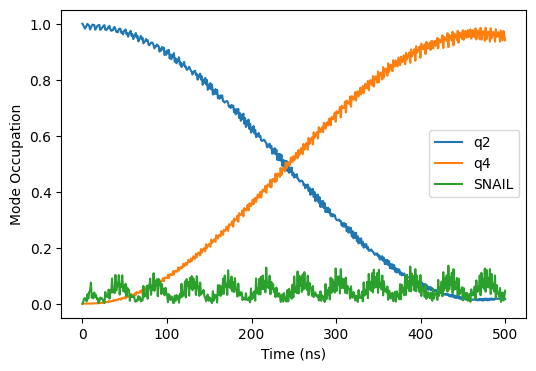

In [22]:
pulse = Pulse(omega=max_pop_freq, amp=max_pop_amp)
H = system_hamiltonian.driven(pulse)

e_ops = [quantum_system.modes_num[m] for m in quantum_system.modes]
solve_result = qt.mesolve(H, psi0, t_list, args=args, options=opts, e_ops=e_ops)

# Plot the state evolution (<n> vs time) for each mode (one plot total)
fig, ax = plt.subplots(figsize=(6, 4))
for k, mode in enumerate(quantum_system.modes):
    ax.plot(t_list, solve_result.expect[k], label=mode.name)
ax.set_xlabel("Time (dt)")
ax.set_ylabel("Mode Occupation")
ax.legend()
plt.show()